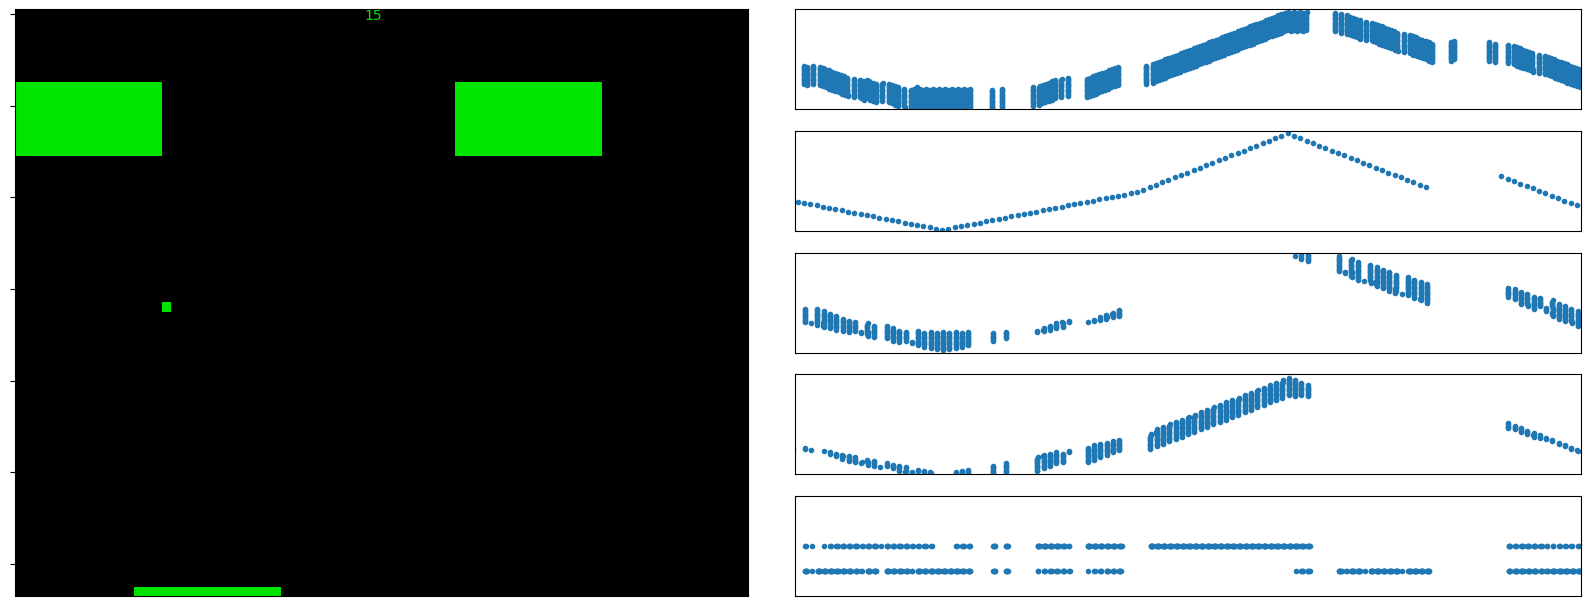

2022-05-03 16:20:49 INFO: Receive callback functools.partial(<function handle_vis_spikes at 0x7f5b6fda7d30>, vis=<spinn_gym.games.breakout.visualiser.visualiser.Visualiser object at 0x7f5b678eba90>) registered to label breakout1
2022-05-03 16:20:49 INFO: Receive callback functools.partial(<function handle_live_spikes at 0x7f5b6fda7dc0>, vis=<spinn_gym.games.breakout.visualiser.visualiser.Visualiser object at 0x7f5b678eba90>) registered to label paddle_pop
2022-05-03 16:20:49 INFO: Receive callback functools.partial(<function handle_live_spikes at 0x7f5b6fda7dc0>, vis=<spinn_gym.games.breakout.visualiser.visualiser.Visualiser object at 0x7f5b678eba90>) registered to label ball_pop
2022-05-03 16:20:49 INFO: Receive callback functools.partial(<function handle_live_spikes at 0x7f5b6fda7dc0>, vis=<spinn_gym.games.breakout.visualiser.visualiser.Visualiser object at 0x7f5b678eba90>) registered to label left_hidden_pop
2022-05-03 16:20:49 INFO: Receive callback functools.partial(<function hand

In [1]:
import spynnaker8 as p
from spinn_gym.games.breakout.visualise_jupyter import jupyter_visualiser
from spinn_gym.games.breakout.automated_breakout import (
    AutomatedBreakout, X_RES, X_SCALE, Y_RES, Y_SCALE)

# ----------------------------------------------------------------------------------------------------------------------
# Initialise Simulation and Parameters
# ----------------------------------------------------------------------------------------------------------------------
run_time_seconds = 60
breakout = AutomatedBreakout(time_scale_factor=2)

# ----------------------------------------------------------------------------------------------------------------------
# Configure Visualiser
# ----------------------------------------------------------------------------------------------------------------------
jupyter_visualiser(breakout, X_RES, X_SCALE, Y_RES, Y_SCALE, 
                   [breakout.paddle_pop, breakout.ball_pop, 
                    breakout.left_hidden_pop, breakout.right_hidden_pop, breakout.decision_input_pop])

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------
# Run Simulation
# ----------------------------------------------------------------------------------------------------------------------
runtime = 1000 * run_time_seconds
print("\nLet\'s play breakout!")
p.run(runtime)
p.end()
print("Simulation Complete")

2022-05-03 16:20:49 WARNING: File spynnaker8 moved to pyNN.spinnaker which points to spynnaker.pyNN. Please fix your imports. In version 8 this will fail completely.
2022-05-03 16:20:49 INFO: Starting execution process
2022-05-03 16:20:49 INFO: Simulating for 120000 1.0ms timesteps using a hardware timestep of 2000us



Let's play breakout!


2022-05-03 16:20:52 INFO: Spalloc max machine generator took 0:00:03.045735 
2022-05-03 16:20:52 INFO: SpYNNakerNeuronGraphNetworkSpecificationReport skipped as cfg Reports:write_network_graph is False
2022-05-03 16:20:52 INFO: Network Specification report took 0:00:00.000693 
2022-05-03 16:20:52 INFO: Splitter reset took 0:00:00.000020 
Adding Splitter selectors where appropriate
|0%                          50%                         100%|
2022-05-03 16:20:52 INFO: Spynnaker splitter selector took 0:00:00.016029 
2022-05-03 16:20:52 INFO: Preallocate for live packet gatherer took 0:00:00.000074 
2022-05-03 16:20:52 INFO: Preallocate for chip power monitor skipped as cfg Reports:write_energy_report is False
2022-05-03 16:20:52 INFO: Preallocate for extra monitor support took 0:00:00.000100 
Partitioning graph vertices
|0%                          50%                         100%|
Partitioning graph edges
|0%                          50%                         100%|
 ========/home/bb